# 以DQN實作木棒台車

In [1]:
# 匯入PIL套件中的Image模組，用於影像處理
from PIL import Image

# 從IPython模組匯入display類別，用來在Jupyter Notebook中顯示圖片
from IPython import display

# 匯入itertools套件中的count函數，用於產生連續數字
from itertools import count

# 匯入matplotlib套件，用於資料視覺化
import matplotlib

# 匯入matplotlib.pyplot模組，用於繪圖
import matplotlib.pyplot as plt

# 匯入numpy套件，用於數值計算與陣列處理
import numpy as np

# 匯入random模組，用於隨機數生成
import random

# 匯入math模組，用於數學運算
import math

# 匯入torch套件，用於建立深度學習模型
import torch

# 匯入torch.nn模組，用於建立神經網路模型
import torch.nn as nn

# 匯入torch.optim模組，用於優化神經網路模型
import torch.optim as optim

# 匯入torch.nn.functional模組，用於神經網路中的函數操作
import torch.nn.functional as F

# 匯入torchvision.transforms模組，用於影像轉換與增強
import torchvision.transforms as T

# 匯入collections套件中的namedtuple, deque，用於資料結構
from collections import namedtuple, deque

# 匯入gym套件，用於建立和操作強化學習環境
import gym

# 匯入gymnasium套件，用於建立和操作強化學習環境
import gymnasium as gym

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
# 設定matplotlib在Jupyter Notebook中內嵌顯示圖片
%matplotlib inline

# 採用互動模式，允許即時更新圖表
plt.ion()

# 判斷是否有可用的GPU，若有則使用GPU，否則使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 建立CartPole-v1環境，並將環境的render_mode設為'rgb_array'
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [4]:
# 定義一個namedtuple，包含state, action, next_state, reward四個欄位，用於儲存每一次的transition資料
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# 定義ReplayMemory類別，用於儲存和管理經驗回放記憶庫
class ReplayMemory(object):

    # 初始化ReplayMemory，設定記憶庫的容量
    def __init__(self, capacity):
        # 使用deque來儲存transition資料，並設定最大長度為capacity
        self.memory = deque([], maxlen = capacity)

    # 儲存一筆transition資料
    def push(self, *args):
        # 將一筆transition(state, action, next_state, reward)加入記憶庫
        self.memory.append(Transition(*args))

    # 隨機抽取batch_size筆transition資料
    def sample(self, batch_size):
        # 使用random.sample()方法從記憶庫中隨機抽取batch_size筆資料並傳回結果
        return random.sample(self.memory, batch_size)

    # 傳回記憶庫中目前的資料筆數
    def __len__(self):
        return len(self.memory)

In [5]:
# 定義DQN卷積神經網路模型，繼承自nn.Module
class DQN(nn.Module):
    # 初始化DQN模型，設定輸入影像的高度h、寬度w，以及輸出行動空間大小outputs
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()

        # 第一層卷積：輸入3通道(RGB)，輸出16通道，卷積核5×5，步幅2
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 5, stride = 2)
        self.bn1 = nn.BatchNorm2d(16)  # 批次正規化

        # 第二層卷積：輸入16通道，輸出32通道，卷積核5×5，步幅2
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 5, stride = 2)
        self.bn2 = nn.BatchNorm2d(32)  # 批次正規化

        # 第三層卷積：輸入32通道，輸出32通道，卷積核5×5，步幅2
        self.conv3 = nn.Conv2d(32, 32, kernel_size = 5, stride = 2)
        self.bn3 = nn.BatchNorm2d(32)  # 批次正規化

        # 定義一個函式，用於計算卷積後的尺寸，預設卷積核大小為5x5，步幅為2
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            # 計算卷積層輸出特徵圖的寬度或高度(假設無padding)
            return (size - (kernel_size - 1) - 1) // stride + 1

        # 計算經過三層卷積後的影像寬度和高度
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))

        # 計算展平後的線性層輸入大小(寬度 × 高度 × 通道數)
        linear_input_size = convw * convh * 32

        # 定義全連接層，將展平後的特徵圖映射到行動空間大小(outputs)
        self.head = nn.Linear(linear_input_size, outputs)

    # 定義前向傳播函式，描述資料如何通過神經網路
    def forward(self, x):
        # 將輸入資料 x 移動到指定的運算裝置(CPU 或 GPU)
        x = x.to(device)

        # 經過三層卷積層，每層後接批次正規化和ReLU激活函數
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        # 展平特徵圖，並通過全連接層輸出行動價值
        return self.head(x.view(x.size(0), -1))

In [6]:
# 定義影像轉換操作，將影像轉為PIL格式，調整大小為40x40，最後轉為張量
resize = T.Compose([
    T.ToPILImage(),  # 將張量或numpy影像轉為PIL影像
    T.Resize(40),    # 調整影像大小為40x40
    T.ToTensor()     # 將PIL影像轉為張量，並標準化至[0, 1]
])

# 定義取得台車位置的函式
def get_cart_location(screen_width):
    # 取得環境的寬度與台車可移動範圍，計算環境寬度(world_width)
    world_width = env.unwrapped.x_threshold * 2

    # 計算螢幕像素與環境寬度的比例(scale)，根據台車位置計算其在螢幕上的像素位置
    scale = screen_width / world_width

    # 傳回台車在螢幕上的像素位置
    return int(env.unwrapped.state[0] * scale + screen_width / 2.0)

# 取得螢幕所有像素，並轉換為張量
def get_screen():
    # 取得環境渲染的影像，轉置為(C, H, W)格式
    screen = env.render().transpose((2, 0, 1))

    # 擷取螢幕下半部像素(台車主要區域)
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height * 0.4): int(screen_height * 0.8)]

    # 定義擷取區域寬度為螢幕寬度的60%
    view_width = int(screen_width * 0.6)

    # 取得台車位置(像素)
    cart_location = get_cart_location(screen_width)

    # 根據台車位置決定擷取範圍
    if cart_location < view_width // 2:
        slice_range = slice(view_width)         # 台車靠近左側，擷取左側區域
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)  # 台車靠近右側，擷取右側區域
    else:
        # 台車在中間位置，擷取以台車為中心的區域
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)

    # 擷取畫面區域
    screen = screen[:, :, slice_range]

    # 將資料轉為連續存放的numpy陣列，並標準化到0~1之間
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255

    # 將numpy陣列轉為張量
    screen = torch.from_numpy(screen)

    # 使用先前定義的resize進行尺寸調整，並增加batch維度(B, C, H, W)
    return resize(screen).unsqueeze(0)

# 重設環境並取得初始狀態
env.reset()

(array([-0.03186749, -0.00608738, -0.04322018, -0.02314834], dtype=float32),
 {})

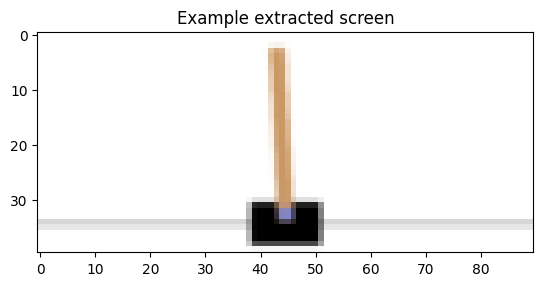

In [7]:
# 建立一個新的圖形視窗
plt.figure()

# 取得擷取的螢幕畫面，轉移到CPU，去除batch維度，調整維度順序為(H, W, C)，並轉為numpy陣列
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')

# 設定圖形標題為"Example extracted screen"
plt.title("Example extracted screen")

# 顯示圖形視窗
plt.show()

In [8]:
# 設定DQN訓練的超參數
BATCH_SIZE = 128    # 每次訓練的批次大小
GAMMA = 0.999       # 折扣因子，影響未來獎勵的權重
EPS_START = 0.9     # ε-greedy初始探索率
EPS_END = 0.05      # ε-greedy最小探索率
EPS_DECAY = 200     # ε衰減速度(控制ε下降快慢)
TARGET_UPDATE = 10  # Target網路更新頻率(每幾回合同步一次)

# 取得螢幕影像的高度與寬度，作為神經網路輸入尺寸
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# 取得行動空間大小，CartPole通常有兩個動作(左、右)
n_actions = env.action_space.n

# 建立兩個DQN網路：policy_net負責學習，target_net負責穩定目標
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)

# 將policy_net權重複製給target_net
target_net.load_state_dict(policy_net.state_dict())

# target_net設定為評估模式(不更新權重)
target_net.eval()

# 使用RMSprop優化器更新policy_net參數
optimizer = optim.RMSprop(policy_net.parameters())

# 建立Experience Replay記憶體，容量設定為10000筆
memory = ReplayMemory(10000)

# 初始化訓練時的全局變數
steps_done = 0          # 記錄已經執行的步數
episode_durations = []  # 紀錄每回合持續的時間(步數)

# 定義行動選擇函數，使用ε-greedy策略平衡探索與利用
def select_action(state):
    # 使用global關鍵字，引用全域變數steps_done
    global steps_done

    # 產生一個0~1之間的隨機數
    sample = random.random()

    # 計算當前ε值，隨著steps_done增加以指數方式從EPS_START衰減至EPS_END
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

    # 累加已執行的步數
    steps_done += 1

    # 以ε-greedy策略選擇行動：大部分時間選擇最優行動，偶爾隨機探索
    if sample > eps_threshold:
        with torch.no_grad():  # 禁用梯度，僅推論模式
            # 選擇Q值最高的動作(策略導向)
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # 隨機選擇一個行動(探索導向)
        return torch.tensor([[random.randrange(n_actions)]], device = device, dtype = torch.long)

# 定義繪圖函式，用來顯示每回合的持續時間
def plot_durations():
    plt.figure(2)  # 建立一個新的圖形視窗，編號為2
    plt.clf()      # 清除視窗中先前的圖形內容

    # 將episode_durations(每回合持續時間)轉為張量
    durations_t = torch.tensor(episode_durations, dtype = torch.float)

    plt.title("Training...")       # 設定圖表標題為"Training..."
    plt.xlabel('Episode')          # 設定X軸標籤為'Episode'
    plt.ylabel('Duration')         # 設定Y軸標籤為'Duration'
    plt.plot(durations_t.numpy())  # 畫出每回合持續時間曲線

    # 如果回合數超過100，則計算並繪製移動平均線
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)  # 計算100回合的移動平均
        means = torch.cat((torch.zeros(99), means))             # 前面補0讓長度對齊
        plt.plot(means.numpy())                                 # 畫出移動平均線

    plt.pause(0.001)            # 短暫暫停，更新畫面
    display.display(plt.gcf())  # 顯示目前圖形

In [9]:
# 定義模型優化函式：從記憶庫中抽樣經驗，計算損失並更新policy_net權重
def optimize_model():
    # 若記憶體資料不足一個batch，則跳過此次優化
    if len(memory) < BATCH_SIZE:
        return

    # 從記憶庫中隨機抽取一個batch的transition資料
    transitions = memory.sample(BATCH_SIZE)

    # 使用zip解包並轉換為namedtuple格式，方便存取各欄位
    batch = Transition(*zip(*transitions))

    # 建立一個mask，用來標記哪些next_state不是終止狀態(非None)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device = device, dtype = torch.bool)

    # 將所有非None的next_state合併成一個大張量(batch形式)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # 將所有state合併成一個大張量，用於批量計算
    state_batch = torch.cat(batch.state)

    # 將所有action合併成一個大張量
    action_batch = torch.cat(batch.action)

    # 將所有reward合併成一個大張量
    reward_batch = torch.cat(batch.reward)

    # 計算當前狀態和所執行動作的Q值(由policy_net預測)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 建立一個張量用來存放下一狀態的Q值，初始值全為0
    next_state_values = torch.zeros(BATCH_SIZE, device = device)

    # 計算非終止狀態的下一步最大Q值(由target_net預測)，並存入next_state_values中
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # 根據Bellman方程式計算預期的Q值：折扣後的下一狀態Q值加上獎勵
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # 定義損失函數為Huber損失(SmoothL1Loss)
    criterion = nn.SmoothL1Loss()

    # 計算當前Q值與目標Q值之間的損失
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 清空優化器中的梯度
    optimizer.zero_grad()

    # 反向傳播計算梯度
    loss.backward()

    # 對梯度進行裁剪，限制範圍在[-1, 1]，避免梯度爆炸
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
    # 更新policy_net的參數
    optimizer.step()

In [10]:
# 訓練DQN模型
num_episodes = 150  # 執行的回合數(預設150)

for i_episode in range(num_episodes):
    env.reset()                           # 重設環境並取得初始狀態
    last_screen = get_screen()            # 取得上一時間點的畫面
    current_screen = get_screen()         # 取得目前畫面
    state = current_screen - last_screen  # 將狀態定義為畫面差值(捕捉變化)

    # 透過無限迴圈進行每回合的步驟，若達終止狀態則提前跳出
    for t in count():
        # 根據目前狀態，透過ε-greedy策略取得動作(行動值最大或隨機探索)
        action = select_action(state)

        # 執行選定的動作，取得新狀態與獎勵
        next_state, reward, terminated, truncated, _ = env.step(action.item())

        # 判斷是否為終止狀態(遊戲結束)
        done = terminated or truncated

        # 將reward轉為張量，並放入計算裝置
        reward = torch.tensor([reward], device = device)

        # 保存當前畫面為上一畫面
        last_screen = current_screen

        # 取得新的畫面(當前時間點)
        current_screen = get_screen()

        # 如果回合未結束，計算下一狀態為畫面差值；否則下一狀態為None
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # 將目前狀態、行動、下一狀態與回饋存入經驗回放記憶體
        memory.push(state, action, next_state, reward)

        # 更新目前狀態為下一狀態，準備進入下一步
        state = next_state

        # 執行神經網路優化函式，更新policy_net權重
        optimize_model()

        # 若回合結束，記錄持續時間並跳出迴圈
        if done:
            episode_durations.append(t + 1)
            break

    # 如果回合數是TARGET_UPDATE的倍數，將policy_net權重複製到target_net(穩定訓練)
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

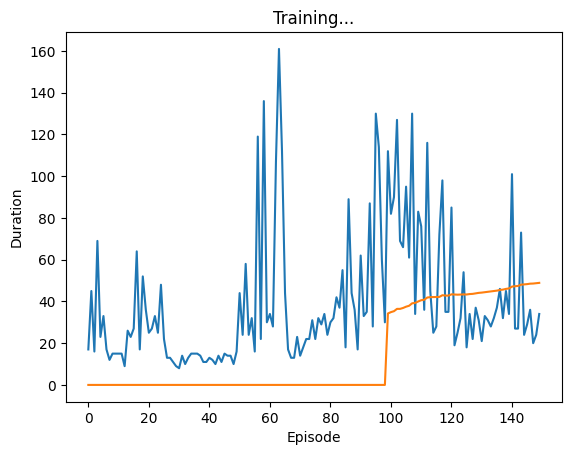

<Figure size 640x480 with 0 Axes>

Complete


<Figure size 640x480 with 0 Axes>

In [11]:
# 繪製訓練過程折線圖
plot_durations()   # 顯示每回合步數變化曲線
print('Complete')  # 輸出訓練完成提示訊息
env.close()        # 關閉遊戲，釋放資源
plt.ioff()         # 停用互動模式，切換為阻塞模式繪圖
plt.show()         # 顯示所有圖形視窗